## Пункт 1. Реализовать СГС для решения ЛР. Исследовать сходимость с разным размером батча

In [230]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from numpy import linalg as LA

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [231]:
# linear function, computes k-th coordinate by k-1 first
#   coefficients - k-1-dim array
#   x - k-1-dim array
def f(coefficients, x):
    return np.sum(coefficients * x)

# scale coord array into [0; 1] interval
def scale_dim(coords):
    mn = coords[0]
    mx = coords[0]
    for i in range(0, len(coords)):
        mn = min(mn, coords[i])
        mx = max(mx, coords[i])
    if mn == mx:
        for i in range(0, len(coords)):
            coords[i] = 0
    else:
        for i in range(0, len(coords)):
            coords[i] = (coords[i] - mn) / (mx - mn)
    return [coords, mn, mx]

# scale all point_set coords into [0; 1] interval
def apply_scaling(points):
    x = points.x.copy()
    y = points.y.copy()
    for k in range(0, points.dim - 1):
        coords = np.asarray([])
        for i in range(0, points.n):
            coords = np.append(coords, points.x[i][k])
        coords = scale_dim(coords)[0]
        for i in range(0, points.n):
            x[i][k] = coords[i]
    y = scale_dim(y)[0] 
    return point_set(points.n, points.dim, x, y)

class point_set:
    # copy ctor :|
    def __init__(self, n, dim, x, y):
        self.n = n
        self.dim = dim
        self.x = x
        self.y = y

# create point_set:
# n - amount of points
# dim - space's dim
# coords_bound - upper bound on absolute first k-1 coordinates value
# coefficients_bound - upper bound on absolute coefficients value
def create_point_set(n, dim, coords_bound, coefficients_bound, coefficients = []):
    x = coords_bound * np.random.random_sample((n, dim - 1))
    if coefficients == []:
        coefficients = coefficients_bound * np.random.random_sample((dim - 1)) - coefficients_bound
    else:
        coefficients = np.asarray(coords_bound)
    y = np.asarray([])
    for i in range(0, n):
        y = np.append(y, f(coefficients, x[i]))
    return point_set(n, dim, x, y)

EPOCH_MAX = 5000
input_2d = create_point_set(200, 2, 10., 2.)
input_3d = create_point_set(200, 3, 10., 2.)
input_small = create_point_set(25, 5, 20., 1.)
input_large = create_point_set(50, 10, 30., 2.)
input_wild = create_point_set(5, 6, 1000., 1.)
input_custom = create_point_set(200, 2, 20, 0, [-5, 3])

In [232]:
# considered linear regression for points_set
# f = sum from i=0 to n-1 of (a*x_i + b - y_i)^2, where a.append(b) = c
#   points - point_set
#   c - k-dim array of coefficients points = [a_0, ..., a_k-2, b]
def linear_regression(points, c):
    f = 0
    for i in range(0, points.n):
        f += (c[0 : points.dim - 1] @ points.x[i] + c[points.dim - 1] - points.y[i]) ** 2
    return f

In [233]:
# calculate gradient [d/da, d/db] of linear regression for points_set by variables x_i, where i in ids
#   points - point_set
#   ids - array of indices for taking gradient
#   coeffs - current linear regression = [a_0, ..., a_k-2, b]
def linear_regression_grad(points, ids, coeffs):
    a = coeffs[0 : points.dim - 1]
    b = coeffs[points.dim - 1]
    grad_a = np.asarray([0.] * len(a))
    grad_b = 0.
    for i in ids:
        grad_a += 2 * (a @ points.x[i] + b - points.y[i]) * points.x[i]
        grad_b += 2 * (a @ points.x[i] + b - points.y[i])
    return np.append(grad_a, grad_b)

In [234]:
# stochastic gradient descent
#   point - point_set
#   batch_size - amount of variables for diff in one epoch
#   gradinet_supplier - :)
#   starting_coeffs - array of point.dim len
#   lr - function (current_lr, epoch)
#   eps - :)
#   epoches - max amount of epoches
#   _param - ignored
# ret:
#   [
#       found coeffs - array of point.dim len,
#       history - array of all epoches changes
#   ]
def sgd(points, batch_size, gradinet_supplier, starting_coeffs, lr, eps, epoches, _param):
    history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    batch_index = 0
    coeffs = starting_coeffs
    current_lr = 0.001
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = gradinet_supplier(points, order[batch_index:to], coeffs)
        coeffs_step = coeffs - current_lr * grad
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        history.append(coeffs)
        coeffs = coeffs_step
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, history]

In [235]:
constant_lr = (lambda current_lr, epoch: 0.001)
colors = ["blue", "red", "green", "orange", "purple", "yellow", "pink"]

# call sgd with each possible batch_size for point_set
#   lr - function (current_lr, epoch)
def batch_size_analyze(points, lr = constant_lr, gd = sgd, param = 0):
    epoches = np.asarray([])
    for batch in range(1, points.dim + 1):
        result = gd(points, batch, linear_regression_grad, np.asarray([0.] * (points.dim)), lr, 1e-6, EPOCH_MAX, param)
        epoches = np.append(epoches, len(result[1]))
    return epoches

# print batch_size_analyze(points, lr)
def print_batch_size_analyze(points, lr = constant_lr, gd = sgd, name='minibatch SGD', params = [0]):
    if params == [0]:
        epoches = batch_size_analyze(points, lr, gd = gd, param = 0)
        plt.plot(np.linspace(1, len(epoches), len(epoches)), epoches)
    else:
        for i in range(0, len(params)):
            epoches = batch_size_analyze(points, lr, gd = gd, param = params[i])
            plt.plot(np.linspace(1, len(epoches), len(epoches)), epoches, color = colors[i % len(colors)], label = "parameter=" + str(params[i]))
        plt.legend()
    plt.xlabel("batch")
    plt.ylabel("epoches")
    plt.title(name + " for n=" + str(points.n) + ", dim=" + str(points.dim))
    plt.show()

In [236]:
# draw lin. reg. values by epoch for point_set & given batch
#   lr - function (current_lr, epoch)
def print_linear_regression_epochs(points, batch, lr = constant_lr, gd = sgd, name = 'minibatch SGD', param = 0):
    result = gd(points, batch, linear_regression_grad, np.asarray([0.] * (points.dim)), lr, 1e-6, EPOCH_MAX, param)

    lin_reg_values = np.asarray([])
    for coeffs in result[1]:
        lin_reg_values = np.append(lin_reg_values, [linear_regression(points, coeffs)])
        
    plt.plot(lin_reg_values)
    plt.xlabel("epoch")
    plt.ylabel("linear regression value")
    plt.title("linear regression by " + name + " for n=" + str(points.n) + ", dim=" + str(points.dim))
    plt.show()

Собственно, сами запуски SGD, minibatch SGD, GD на различных наборах точек:

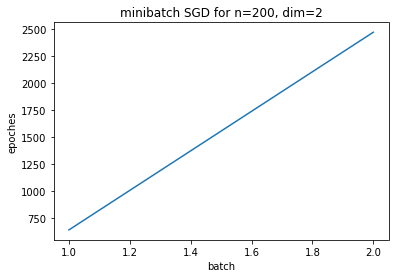

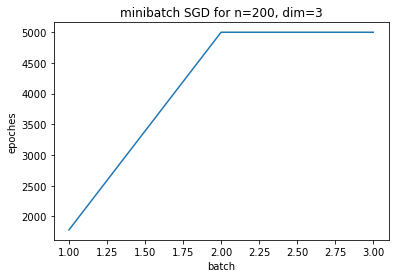

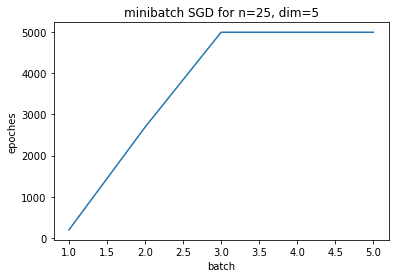

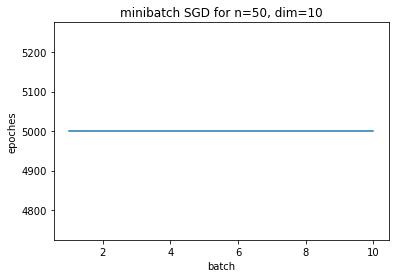

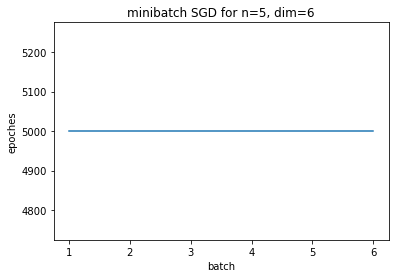

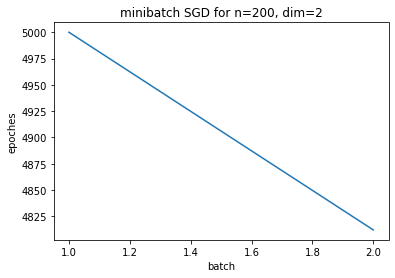

In [237]:
print_batch_size_analyze(input_2d)
print_batch_size_analyze(input_3d)
print_batch_size_analyze(input_small)
print_batch_size_analyze(input_large)
print_batch_size_analyze(input_wild)
print_batch_size_analyze(input_custom)

Микровывод: как можно видеть, mini-batch SGD для лин. регрессии без каких либо оптимизаций действительно сильно "скачет" в показаниях сходимости для ранзных величин batch и размерности пространства точек. В подавляющем большинстве случаев сойтись не получается даже за 5000 эпох :( что подтверждает неэффиктивность вычисления частичного градиента для случайного набора данных.

Однако также, можно заметить следующие моменты:
* редко бывают случие, когда бы не сошелся SGD, но сошлись minibatch SGD или GD
* для batch < dim, сходимость достигается (если и достигается) за меньшее число эпох, по сравнению с ГС из лабораторной 1

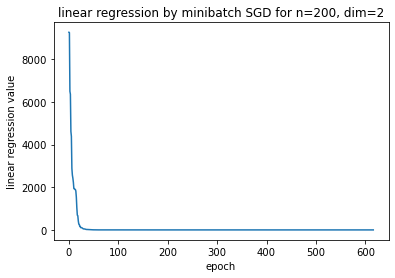

In [238]:
print_linear_regression_epochs(input_2d, 1)

Тем не менее в случаях, когда ГС (СГС) сходится, значения линейной регрессии действительно уменьшаются со временем, а значит, проблема расхождения за 5000 эпох действительно возникает из-за колеблющегося графика минимизирующей функции и констанного learning rate.

Похоже на ситуацию с функций Розенброка из первой лабораторной. Там мы решили эту проблему путем пересчета lr через ступенчатую функцию, и, как видно на графиках ниже, здесь она так же помогла. Следовательно расходимость minibatch SGD без модификаций для большинства расмотренных функций - оправдана

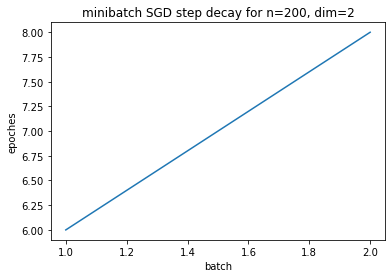

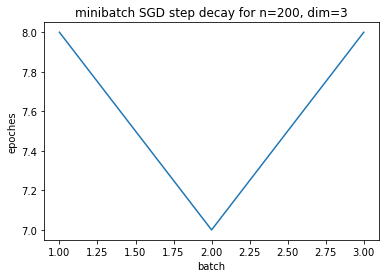

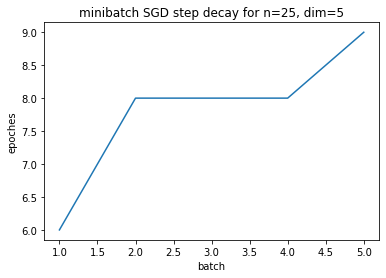

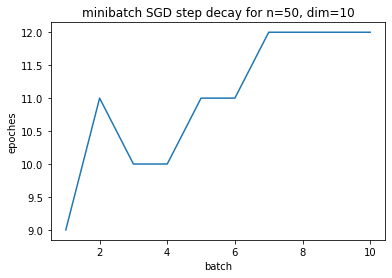

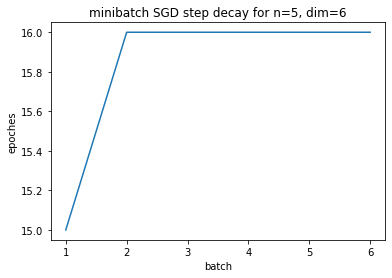

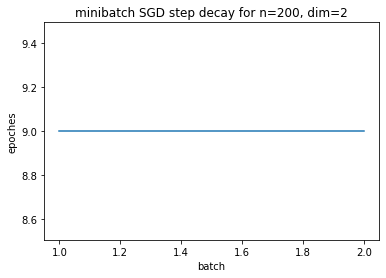

In [239]:
def step_decay(lr, epoch, epochs_drop = 2, drop = 0.5):
   return lr * pow(drop, floor((1 + epoch) / epochs_drop))

print_batch_size_analyze(input_2d, step_decay, name = "minibatch SGD step decay")
print_batch_size_analyze(input_3d, step_decay, name = "minibatch SGD step decay")
print_batch_size_analyze(input_small, step_decay, name = "minibatch SGD step decay")
print_batch_size_analyze(input_large, step_decay, name = "minibatch SGD step decay")
print_batch_size_analyze(input_wild, step_decay, name = "minibatch SGD step decay")
print_batch_size_analyze(input_custom, step_decay, name = "minibatch SGD step decay")

## Пункт 2. Исследовать влияние предварительной нормализации данных на сходимость

Рассмотрим scaling к диапазону [0, 1]

In [240]:
# check if all coords are scaled
def debug_check_scaling(points, l, r):
    ok = 1
    for i in range(0, points.n):    
        for k in range(0, points.dim - 1):
            ok = ok & (l <= points.x[i][k] <= r)
        ok = ok & (l <= points.y[i] <= r)
    return ok

# call sgd with each possible batch_size for point_set & scaled_point_set
# lr - function (current_lr, epoch)
def scaling_batch_size_compare(points, lr = constant_lr, name = "minibatch SGD"):
    epoches_points = batch_size_analyze(points, lr)
    plt.plot(np.linspace(1, len(epoches_points), len(epoches_points)), epoches_points, label='original point set', color='red')
    
    scaled_points = points
    scaled_points = apply_scaling(scaled_points)
    print("check scaling: " + str(debug_check_scaling(scaled_points, 0, 1)))
    epoches_points = batch_size_analyze(scaled_points, lr)
    plt.plot(np.linspace(1, len(epoches_points), len(epoches_points)), epoches_points, label='scaled [0; 1] point set', color='blue')
    
    
    plt.xlabel("batch")
    plt.ylabel("epoches")
    plt.title(name + " for n=" + str(points.n) + ", dim=" + str(points.dim))
    plt.legend()
    plt.show()

check scaling: 1


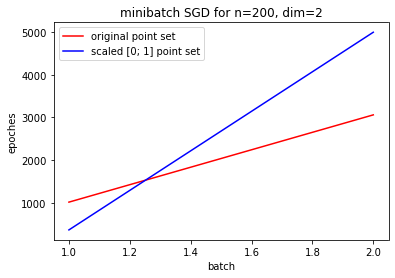

check scaling: 1


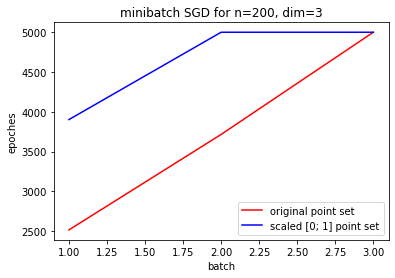

check scaling: 1


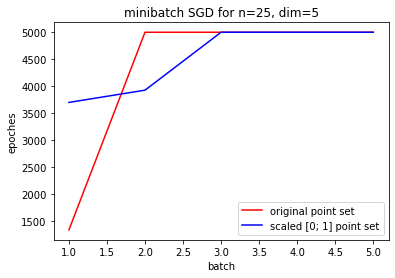

check scaling: 1


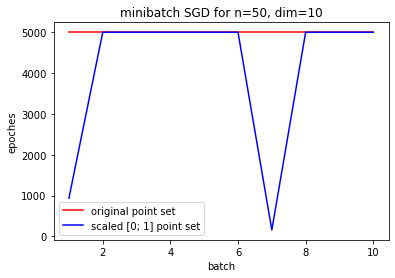

check scaling: 1


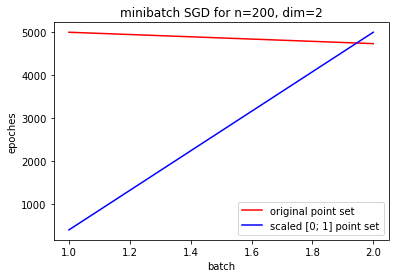

check scaling: 1


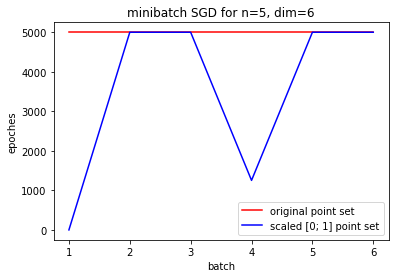

In [241]:
scaling_batch_size_compare(input_2d)
scaling_batch_size_compare(input_3d)
scaling_batch_size_compare(input_small)
scaling_batch_size_compare(input_large)
scaling_batch_size_compare(input_custom)
scaling_batch_size_compare(input_wild)

Микровывод: поскольку набор точек для скаллинга всегда случайный, то нельзя сделать вывод, что скаллинг всегда выигрывает по скорости сходимости у стандартного minibatch SGD. Можно заметить, что чем плотнее изначально расположены точки, тем хуже в вопросе сходимости работает minibatch SGD со скаллингом. Так же ради интереса проверим со ступенчатой функцией: (там вообще летает)

check scaling: 1


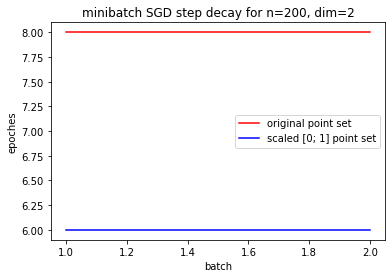

check scaling: 1


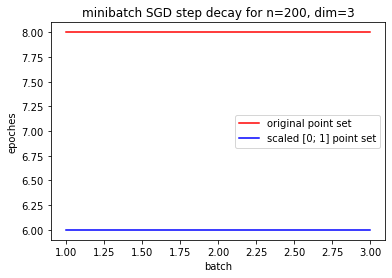

check scaling: 1


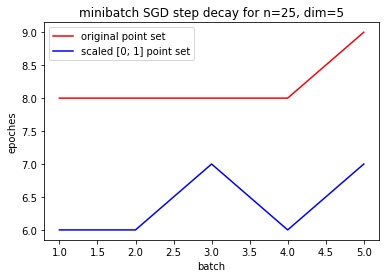

check scaling: 1


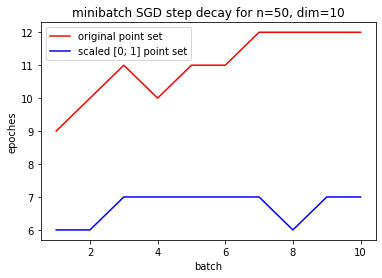

check scaling: 1


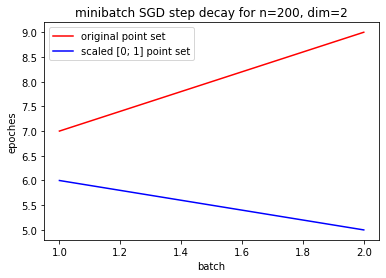

check scaling: 1


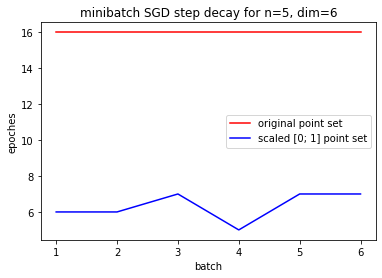

In [242]:
scaling_batch_size_compare(input_2d, step_decay, name = "minibatch SGD step decay")
scaling_batch_size_compare(input_3d, step_decay, name = "minibatch SGD step decay")
scaling_batch_size_compare(input_small, step_decay, name = "minibatch SGD step decay")
scaling_batch_size_compare(input_large, step_decay, name = "minibatch SGD step decay")
scaling_batch_size_compare(input_custom, step_decay, name = "minibatch SGD step decay")
scaling_batch_size_compare(input_wild, step_decay, name = "minibatch SGD step decay")

## Пункт 3

In [243]:
# stochastic gradient descent with momentum
#   point - point_set
#   batch_size - amount of variables for diff in one epoch
#   gradinet_supplier - :)
#   starting_coeffs - array of point.dim len
#   lr - function (current_lr, epoch)
#   eps - :)
#   epoches - max amount of epoches
#   betta - parameter
# ret:
#   [
#       found coeffs - array of point.dim len,
#       history - array of all epoches changes
#   ]
def sgd_with_momentum(points, batch_size, gradinet_supplier, starting_coeffs, lr, eps, epoches, betta):
    history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    batch_index = 0
    coeffs = starting_coeffs
    current_lr = 0.001
    grad = np.asarray([0] * points.dim)
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = betta * grad + current_lr * gradinet_supplier(points, order[batch_index:to], coeffs)
        coeffs_step = coeffs - grad
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        history.append(coeffs)
        coeffs = coeffs_step
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, history]

### SGD with momentum

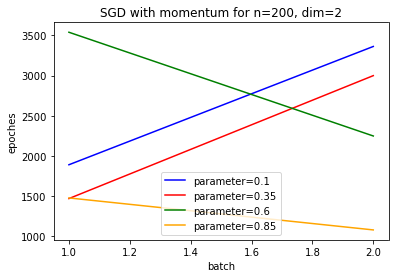

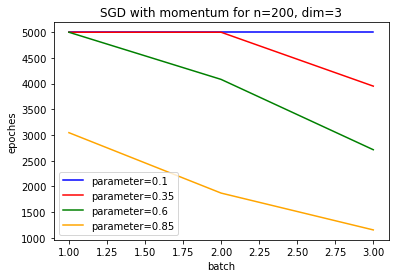

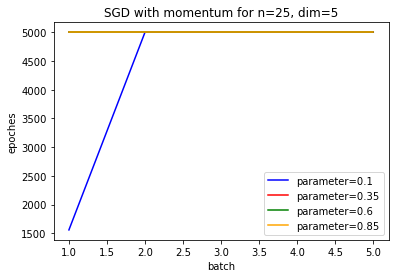

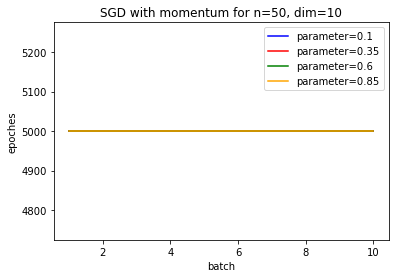

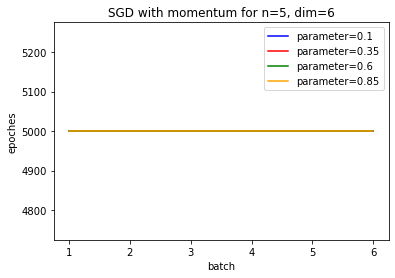

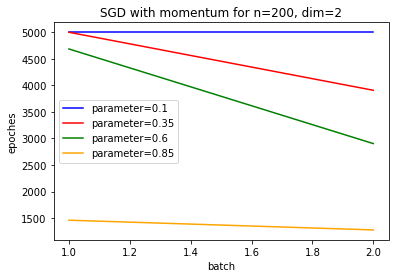

In [244]:
print_batch_size_analyze(input_2d, gd=sgd_with_momentum, name='SGD with momentum', params=[0.1, 0.35, 0.6, 0.85])
print_batch_size_analyze(input_3d, gd=sgd_with_momentum, name='SGD with momentum', params=[0.1, 0.35, 0.6, 0.85])
print_batch_size_analyze(input_small, gd=sgd_with_momentum, name='SGD with momentum', params=[0.1, 0.35, 0.6, 0.85])
print_batch_size_analyze(input_large, gd=sgd_with_momentum, name='SGD with momentum', params=[0.1, 0.35, 0.6, 0.85])
print_batch_size_analyze(input_wild, gd=sgd_with_momentum, name='SGD with momentum', params=[0.1, 0.35, 0.6, 0.85])
print_batch_size_analyze(input_custom, gd=sgd_with_momentum, name='SGD with momentum', params=[0.1, 0.35, 0.6, 0.85])

Микровывод: SGD with momentum помогает улучшить сходимость для некоторых фукнкций, однако требователен к подбору параметра и плодит много рантайм ворнингов из-за переполнения :(
### SGD with Nesterov momentum

In [245]:
# calculate gradient [d/da, d/db] of linear regression for points_set by variables x_i, where i in ids
#   points - point_set
#   ids - array of indices for taking gradient
#   coeffs - current linear regression = [a_0, ..., a_k-2, b]
#   betta - parameter
#   grad - previous step gradined
def nesterov_linear_regression_grad(points, ids, coeffs, betta, grad):
    a = coeffs[0 : points.dim - 1]
    b = coeffs[points.dim - 1]
    grad_a = np.asarray([0.] * len(a))
    grad_b = 0.
    prev_grad_a = grad[0 : points.dim - 1]
    prev_grad_b = grad[points.dim - 1]
    for i in ids:
        grad_a += 2 * (a @ (points.x[i] - betta * prev_grad_a) + b - points.y[i] - betta * prev_grad_b) * (points.x[i] - betta * prev_grad_a)
        grad_b += 2 * (a @ (points.x[i] - betta * prev_grad_a) + b - points.y[i] - betta * prev_grad_b)
    return np.append(grad_a, grad_b)

# stochastic gradient descent with Nesterov momentum
#   point - point_set
#   batch_size - amount of variables for diff in one epoch
#   _gradinet_supplier - ignored
#   starting_coeffs - array of point.dim len
#   lr - function (current_lr, epoch)
#   eps - :)
#   epoches - max amount of epoches
#   betta - parameter
# ret:
#   [
#       found coeffs - array of point.dim len,
#       history - array of all epoches changes
#   ]
def sgd_with_nesterov_momentum(points, batch_size, _gradinet_supplier, starting_coeffs, lr, eps, epoches, betta):
    history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    batch_index = 0
    coeffs = starting_coeffs
    current_lr = 0.001
    grad = np.asarray([0] * points.dim)
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = betta * grad + current_lr * nesterov_linear_regression_grad(points, order[batch_index:to], coeffs, betta, grad)
        coeffs_step = coeffs - grad
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        history.append(coeffs)
        coeffs = coeffs_step
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, history]

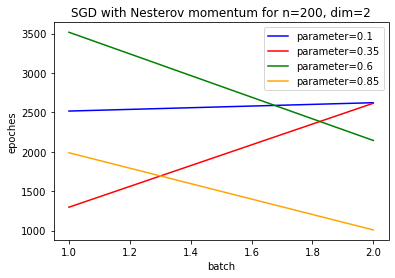

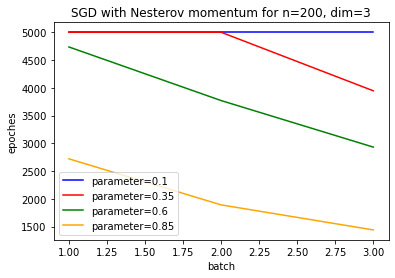

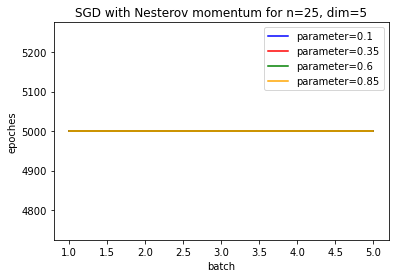

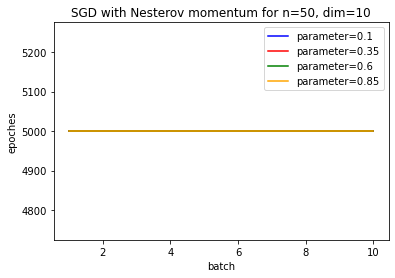

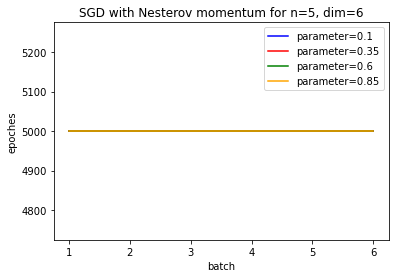

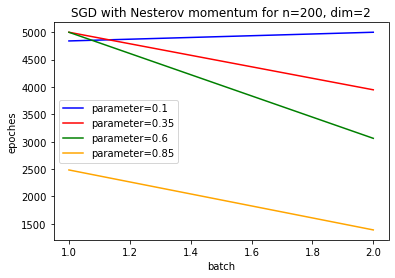

In [246]:
print_batch_size_analyze(input_2d, gd=sgd_with_nesterov_momentum, name='SGD with Nesterov momentum', params=[0.1, 0.35, 0.6, 0.85])
print_batch_size_analyze(input_3d, gd=sgd_with_nesterov_momentum, name='SGD with Nesterov momentum', params=[0.1, 0.35, 0.6, 0.85])
print_batch_size_analyze(input_small, gd=sgd_with_nesterov_momentum, name='SGD with Nesterov momentum', params=[0.1, 0.35, 0.6, 0.85])
print_batch_size_analyze(input_large, gd=sgd_with_nesterov_momentum, name='SGD with Nesterov momentum', params=[0.1, 0.35, 0.6, 0.85])
print_batch_size_analyze(input_wild, gd=sgd_with_nesterov_momentum, name='SGD with Nesterov momentum', params=[0.1, 0.35, 0.6, 0.85])
print_batch_size_analyze(input_custom, gd=sgd_with_nesterov_momentum, name='SGD with Nesterov momentum', params=[0.1, 0.35, 0.6, 0.85])

Микровывод: получили несколько изменный SGD with momentum, линии стали плавнее, что не очень понятно, хорошо или плохо. Функции, которые не сходили раньше, не сходятся и сейчас :( Запускал со ступенчатой функций и эти ГС, сходимость хотя бы при паре коэффициентов была у всех функций. Следовательно езе раз убеждаемся, что SGD, SGD with momentum и SGD with Nesterov momentum похоже друг на друга в плане производительности, и для сходимости требуется что-то более чуткое к лернинг рэйту и измерению